In [1]:
import os
import sys

# Set up working directory
if os.getcwd().endswith("notebooks"):
    current_dir = os.getcwd()
    up_dir = current_dir.split("/")[0:-1]
    os.chdir("/".join(up_dir))

from src.preprocess_data import *
from src.visualize_data import *
from src.models import *
from test_parameters import *


# Read the relevant input data
all_data = pd.read_csv("csv_data/07_feature_engineering_and_cleaning.csv")
X = all_data.drop(["location", "date", "zika_cases"], axis=1).values
y = all_data["zika_cases"].values
# Read the small dataset
with open("csv_data/X.pkl", "rb") as f:
    X_small = dill.load(f)
with open("csv_data/y.pkl", "rb") as f:
    y_small = dill.load(f)

# Make sure to use CPU for these small models
setup_gpu(gpu=False)

Using TensorFlow backend.


## Input Data

Number of non-zika cases: 100974
Number of zika cases: 15135
Percent of non-zika cases: 86.9648347673307
Percent of zika cases: 13.035165232669302
Total number of rows: 116109


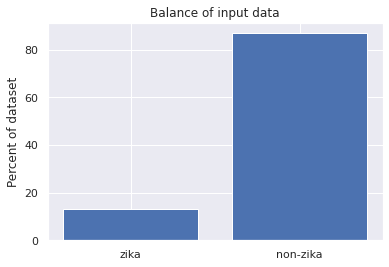

Number of non-zika cases: 209
Number of zika cases: 1004
Percent of non-zika cases: 17.230008244023086
Percent of zika cases: 82.76999175597692
Total number of rows: 1213


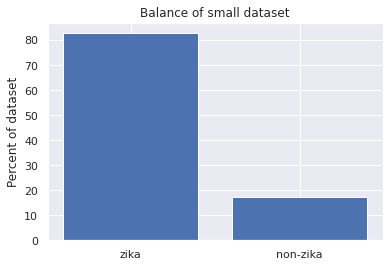

In [2]:
# Plot data balance for large dataset
view_data_balance(X, y, data_type="input data")

# Plot balance for small dataset
view_data_balance(X_small, y_small, data_type="small dataset")

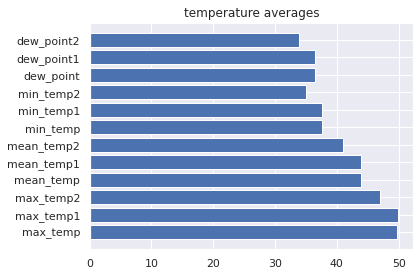

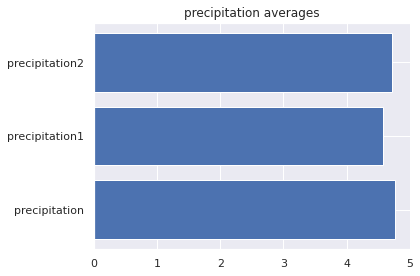

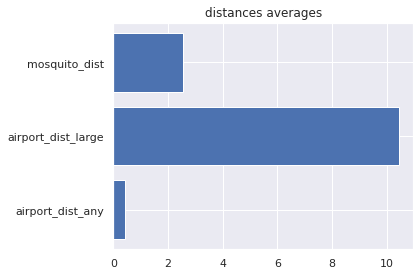

<Figure size 432x288 with 0 Axes>

In [3]:
# Plot the averages for each data column
plot_averages(all_data)

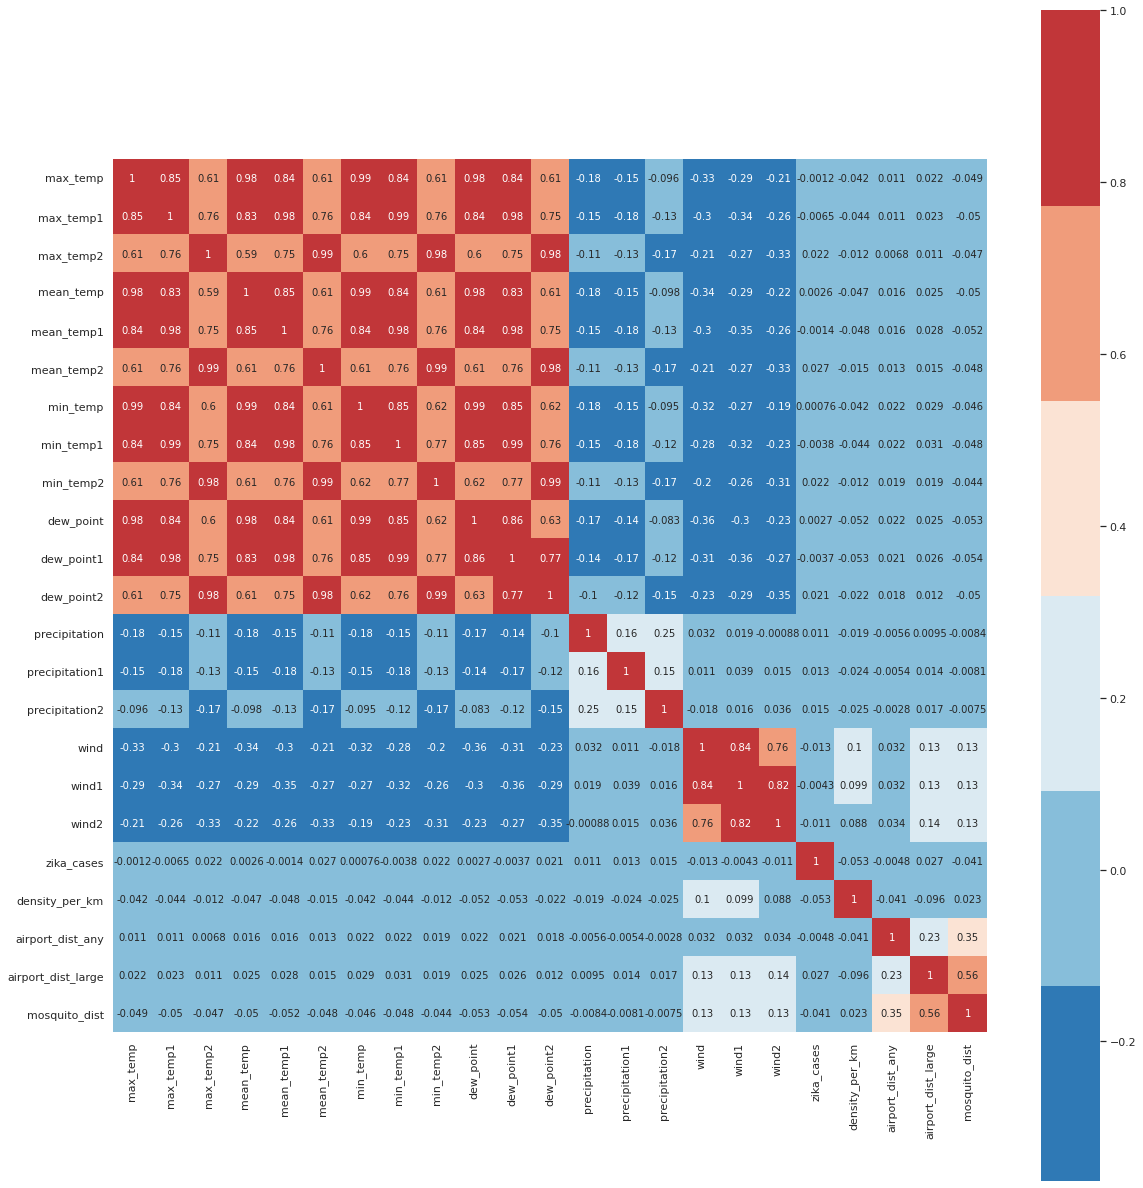

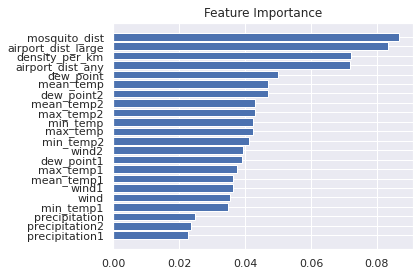

<Figure size 432x288 with 0 Axes>

In [4]:
# Look at correlation between features and the number of cases
plot_feature_output_correlation(all_data)

## Classifiers
### Accuracy as a function of date

In [5]:
# Read in the data as a function of the date
data_list = get_data(data_choice="by_date")

# Set up parameters
nn_params = {
    "epochs": [10],
    "batch_size": [100]
}
neighbours = [50]
estimators = [50]

neural net params: {'epochs': [10], 'batch_size': [100]}
number of neighbours: [50]
estimators: [50]


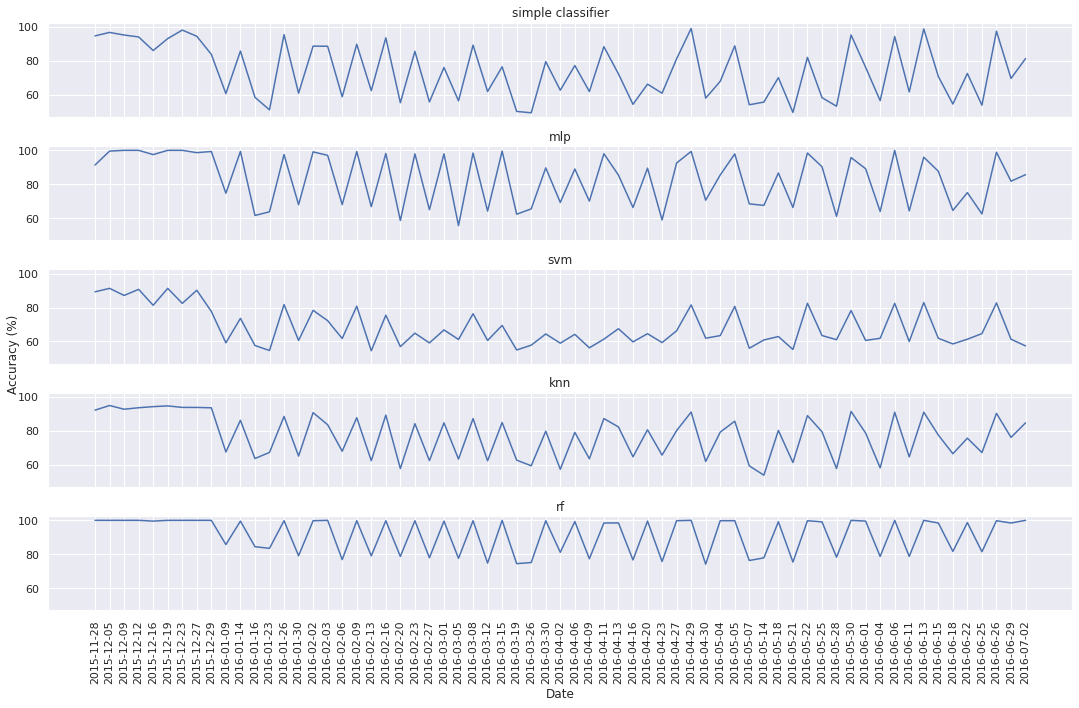

<Figure size 432x288 with 0 Axes>

In [6]:
# Set up empty variables
best_results = {
    "simple_classifier": [],
    "mlp": [],
    "svm": [],
    "knn": [],
    "rf": []
}
dates = []

for data in data_list:
    # If all the training data for this date is the same, then don't use this date
    if len(np.unique(data["y_train"])) == 1:
        continue

    # Test the simple classifier parameters
    simple_classifier = build_simple_classifier(data["X_train"])
    simple_classifier_results = test_nn(simple_classifier, data, 'simple_classifier', nn_params, verbose=False,)
    
    # Test MLP
    mlp = build_mlp(data["X_train"])
    mlp_results = test_nn(mlp, data, 'mlp', nn_params, verbose=False)

    # Test SVM
    svm_classifier = build_svm()
    svm_results = model_predict('svm', svm_classifier, data)

    # Test KNN
    knn_results = test_knn(data, neighbours, verbose=False)
    
    # Test RF
    rf_results = test_rf(data, estimators, verbose=False)

    # Visualize results
    all_results = [simple_classifier_results, mlp_results, [svm_results], knn_results, rf_results]

    # Sort all results
    for result_list in all_results:
        # Sort according to accuracy
        sorted_list = sorted(result_list, key=itemgetter("accuracy"), reverse=True)
        result = sorted_list[0]
        best_results[result["name"]].append(result["accuracy"]*100)

    dates.append(data["date"])

print("neural net params: {}".format(nn_params))
print("number of neighbours: {}".format(neighbours))
print("estimators: {}".format(estimators))
plot_accuracy_by_date_subplot(dates, best_results)

### Simple Classifier

In [9]:
data_sm = get_data(data_choice="small_data")[0]
print("The length of the training data is {}".format(len(data_sm["X_train"])))
print("The length of the testing data is {}".format(len(data_sm["X_test"])))

# Set up parameters
nn_params = {
    "epochs": [10, 50, 100, 200],
    "batch_size": [10, 50, 100, 200]
}
neighbours = [1, 5, 10, 50, 100, 200, 500]
estimators = [1, 5, 10, 50, 100, 200, 500]

# Set up the simple classifier
simple_classifier_sm = build_simple_classifier(data_sm["X_train"])
print(simple_classifier_sm.summary())

The length of the training data is 970
The length of the testing data is 243
Model: "sequential_131"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_586 (Dense)            (None, 12)                300       
_________________________________________________________________
dense_587 (Dense)            (None, 12)                156       
_________________________________________________________________
dense_588 (Dense)            (None, 1)                 13        
Total params: 469
Trainable params: 469
Non-trainable params: 0
_________________________________________________________________
None


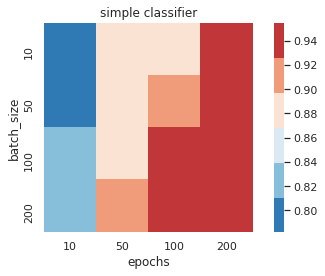

<Figure size 432x288 with 0 Axes>

In [10]:
# Run simple classifier 
simple_classifier_results_sm = test_nn(simple_classifier_sm, data_sm, 'simple_classifier', nn_params, verbose=False,)

# Visualize Results
plot_nn_heatmap(simple_classifier_results_sm)

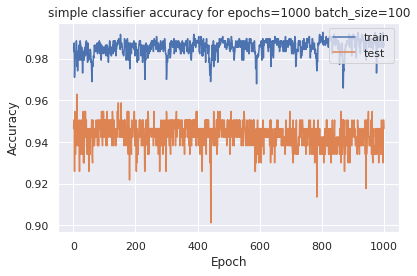

In [11]:
# Try 1000 epochs
params = {
    "epochs": [1000],
    "batch_size": [100]
}
simple_classifier_results_1000 = test_nn(simple_classifier_sm, data_sm, 'simple_classifier', params, verbose=False,)

# Visualize Results
plot_history(simple_classifier_results_1000)

In [17]:
# Set up input data using the large dataset
data_lg = get_data(data_choice="big_data")[0]
print("The length of the training data is {}".format(len(data_lg["X_train"])))
print("The length of the testing data is {}".format(len(data_lg["X_test"])))

# Set up the simple classifier
simple_classifier_lg = build_simple_classifier(data_lg["X_train"])

The length of the training data is 92887
The length of the testing data is 23222


In [ ]:
# Run simple classifier 
simple_classifier_results_lg = test_nn(simple_classifier_lg, data_lg, 'simple_classifier', nn_params, verbose=False,)

# Visualize Results
plot_nn_heatmap(simple_classifier_results_lg)

### Multi Layer Perceptron

In [12]:
# Set up the multi layer perceptron for the small dataset
mlp_sm = build_mlp(data_sm["X_train"])
print(mlp_sm.summary())

Model: "sequential_132"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_589 (Dense)            (None, 200)               4800      
_________________________________________________________________
dense_590 (Dense)            (None, 200)               40000     
_________________________________________________________________
dense_591 (Dense)            (None, 200)               40000     
_________________________________________________________________
dense_592 (Dense)            (None, 200)               40000     
_________________________________________________________________
dense_593 (Dense)            (None, 200)               40000     
_________________________________________________________________
dense_594 (Dense)            (None, 1)                 200       
Total params: 165,000
Trainable params: 165,000
Non-trainable params: 0
______________________________________________

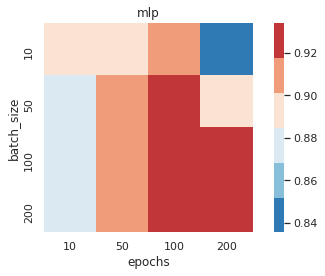

<Figure size 432x288 with 0 Axes>

In [13]:
# Run MLP for small dataset
mlp_results_sm = test_nn(mlp_sm, data_sm, 'mlp', nn_params, verbose=False,)

# Visualize Results
plot_nn_heatmap(mlp_results_sm)

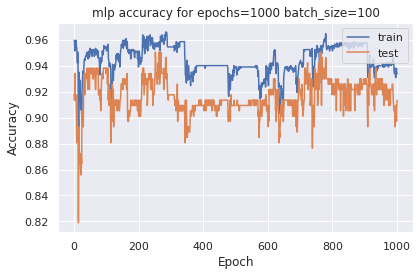

In [14]:
# Try 1000 epochs
mlp_results_1000 = test_nn(mlp_sm, data_sm, 'mlp', params, verbose=False,)

# Visualize Results
plot_history(mlp_results_1000)

In [ ]:
# Set up the multi layer perceptron for the large dataset
mlp_lg = build_mlp(data_lg["X_train"])
print(mlp_lg.summary())

In [ ]:
# Run simple classifier 
mlp_results_lg = test_nn(mlp_lg, data_lg, 'mlp', nn_params, verbose=False,)

# Visualize Results
plot_nn_heatmap(mlp_results_lg)

### SVM

In [15]:
# Start with small data again
svm_classifier = svm.SVC()
svm_results_sm = model_predict(
        'svm',
        svm_classifier,
        data_sm,
    )
print("accuracy for small dataset: {}".format(svm_results_sm["accuracy"]))

accuracy for small dataset: 0.8148148148148148


In [18]:
# Now try large dataset
svm_results_lg = model_predict(
        'svm',
        svm_classifier,
        data_lg,
    )
print("accuracy for large dataset: {}".format(svm_results_lg["accuracy"]))

accuracy for large dataset: 0.8668934630953407


### K-Nearest Neighbours

In [ ]:
# Run for demo
# Test various neighbours with the small dataset
knn_results_sm = test_knn(data_sm, neighbours)

# Visualize Results
plot_knn_bar(knn_results_sm)

In [ ]:
# Test various neighbours with the large dataset
knn_results_lg = test_knn(data_lg, neighbours)

# Visualize results
plot_knn_bar(knn_results_lg)

### Random Forest

In [ ]:
# Test RF on small dataset
rf_results_sm = test_rf(data_sm, estimators, verbose=False)

In [ ]:
# Test RF on large dataset
rf_results_lg = test_rf(data_lg, estimators, verbose=False)

### All Classifiers

In [ ]:
# Look at all results for the small dataset
all_results_sm = [simple_classifier_results_sm, mlp_results_sm, [svm_results_sm], knn_results_sm, rf_results_sm]
plot_all_results(all_results_sm)

In [ ]:
# Look at all results for the large dataset
all_results_lg = [simple_classifier_results_lg, mlp_results_lg, [svm_results_lg], knn_results_lg, rf_results_lg]
plot_all_results(all_results_lg)